# Factorial Hiddon Markov Model
In this notebook, we apply the FHMM disaggregation method implemented in the NILMTK package on the REDD dataset. We then make improvements on the NILMTK implementation and compare the results. For data processing, we use the tools availalble in NILMTK. 

Factorial hidden markov models (FHMM) are generalizations of hidden markov models (HMMs) where the hidden state is factored into multiple state variables (Ghahramani and Jordan, 1997). We first describe the disaggregation problem in terms of HMMs, then describe it in the FHMM framework. 

In this problem, we wish to infer a time series of the hidden states of each appliance in the household. If we only wished to infer the hidden state of one appliance, for example, a refrigerator, we can model it as an HMM. The hidden state would be whether the fridge is on or off. The observed state would be the aggregated energy reading for the entire home. 
$$z_t \rightarrow z_{t+1} \\
\hspace{1mm} \downarrow \hspace{10mm} \downarrow \hspace{1mm} \\
x_t \hspace{6mm} x_{t+1}$$
where $z$ refers to the hidden state and takes on a discrete value (on/off) and $x$ is the observed state and takes on a continuous value. The emission probability, the probability of making an observation $x_t$ given $z_t$, $P(x_t|z_t)$ can be modeled as a Gaussian. 

An FHMM is similar to HMM, but for each observation, instead of having one hidden state, there are multiple hidden states we need to infer. This would be the case if we wanted to infer the status of multiple appliances in the home. We can model this as an HMM with a distinct state for each possible combination of states: fridge on + lights off, fridge on + lights on, etc. Alternatively, we can let the state be represented by a collection of state variables, 
$$z_t = z^1_t, z^2_t, ...$$
each of which can take on an on/off value. In the energy disaggregation problem, the observed state is the sum of the different hidden states (Kolter and Jakkola, 2012). The hidden states are drawn from a multinomial distribution and the transition probability can be factored as: 
$$P(z_t|z_{t-1}) = \Pi_{m=1}^M P(z_t^{(m)}|z_{t-1}^{(m)})$$
The emissions are Gaussian: 
$$ P(x_t|z_t) = \mathcal{N} (\Sigma_{i=1}^{N} \mu^{(i)}, \Sigma)$$
The additive model is a special case of the general FHMM. 

In [1]:
from __future__ import print_function, division
import time
from matplotlib import rcParams
import matplotlib.pyplot as plt
%matplotlib inline
rcParams['figure.figsize'] = (13, 6)
plt.style.use('ggplot')

from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.disaggregate import fhmm_exact

/Users/kyu/Google Drive/AM207project/nilmtk/nilmtk/node.py:2: ImportWarning: Not importing directory 'nilm_metadata': missing __init__.py
  from nilm_metadata import recursively_update_dict


## Read in data and do data processing
Read in data and separate into training and testing sets using functions available in NILMTK. 

In [2]:
train = DataSet('redd.h5')
test = DataSet('redd.h5')

# we do not use the 4th house because it does not contain a fridge
training_houses = [1,2,3]
test_houses = 5

test_elec = test.buildings[test_houses].elec

# appliances
appliances = ['fridge', 'microwave']

We train with only the k=3 top devices. However, we find that the top devices are not the same for each house. We decided to use fridge, sockets, and light because they are the most common appliances to occur in the top 3 and are present in both the training and test set. 

The appliances have different numbers for each home, presenting difficulties for using the disaggregation algorithms across different houses. We manually set the appliance numbers of the test set to deal with this problem. 

## FHMM implementation in NILMTK
The NILMTK implementation takes the approach of expanding the HMM model state space to have every combination of states of eveyr appliance (eg. fridge on + lights off, fridge on + lights on, etc.). In the NILMTK implementation, we use the train_across_buildings function in the FHMM class. The function takes in the training dataset, and we give it a list of houses and appliances we want to train. The code loops through each appliance, then each building, and checks that the on/off difference are larger than a preset value. The data from all buildings for a particular appliance is modeled as an HMM with two hidden states (on/off) and Gaussian emissions. The package hmmlearn is used to fit the means for the two states. hmmlearn uses EM to fit the parameters. This is done for every appliance, so that for every appliance we have an HMM. The parameters for each appliance are then combined into an FHMM by taking every combination of the possible states for every appliance and summing the power means for each state. 

To perform disaggregation, the predict function of hmmlearn is used, which finds the most likely state sequence that corresponds to a set of observations. hmmlearn has two options for the decoder algorithm, Viterbi and MAP, with Viterbi being the default. 

In [3]:
# initialized FHMM model
fhmm = fhmm_exact.FHMM()

# train model on training houses. We downsample to a period of 10s. 
fhmm.train_across_buildings(train, training_houses, appliances, min_activation=0.001, sample_period=10)

Training for fridge
0.237655827726
0.180426424327
0.150136029288
Means for fridge are
[[   4.92556685]
 [ 167.10873899]]
Training for microwave
0.0142434597823
0.0417303307202
0.00235112350116
Means for microwave are
[[   3.60750263]
 [ 392.77066572]]


In [4]:
# name of file to save disaggregated output to
disag_filename = 'redd-disag-fhmm_exact.h5'
output = HDFDataStore(disag_filename, 'w')

# perform disaggregation
fhmm.disaggregate_across_buildings(test, output, [test_houses], sample_period=10)
output.close()

Disaggregating for building 5


/Users/kyu/Google Drive/AM207project/nilmtk/nilmtk/metergroup.py:901: UserWarning: As a quick implementation we only get Good Sections from the first meter in the meter group.  We should really return the intersection of the good sections for all meters.  This will be fixed...
  warn("As a quick implementation we only get Good Sections from"


Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.


In [5]:
# Read disaggreated data from the file we just save to
disag_fhmm = DataSet(disag_filename)
disag_fhmm_elec = disag_fhmm.buildings[test_houses].elec

3     0.122602
18    0.237859
dtype: float64


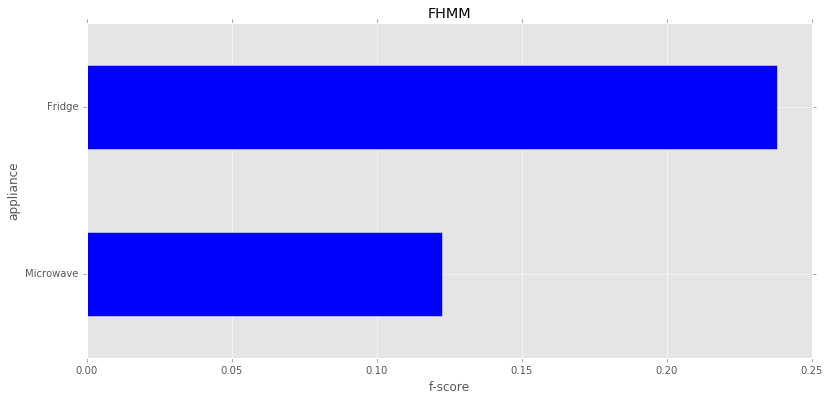

In [6]:
# make plots of f1 score
from nilmtk.metrics import f1_score, accuracy_score, recall_score, precision_score
f1_fhmm = f1_score(disag_fhmm_elec, test_elec)
print(f1_fhmm)
f1_fhmm.index = disag_fhmm_elec.get_labels(f1_fhmm.index)
f1_fhmm.plot(kind='barh')
plt.ylabel('appliance');
plt.xlabel('f-score');
plt.title("FHMM");

3     0.483429
18    0.172625
dtype: float64


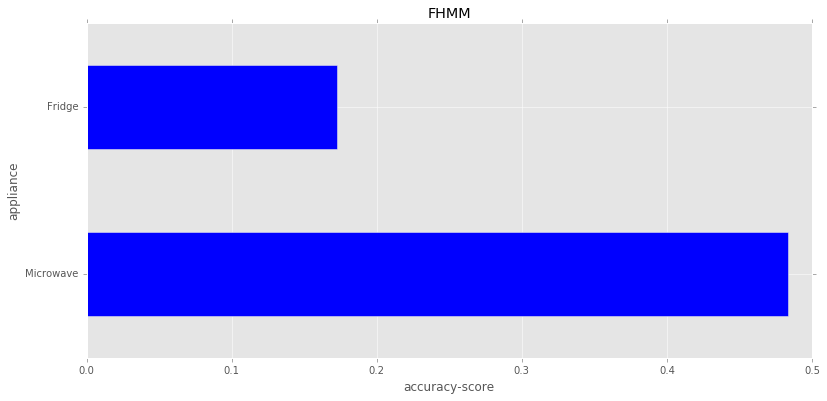

In [7]:
# make plot of accuracy metric
accuracy_fhmm = accuracy_score(disag_fhmm_elec, test_elec)
print(accuracy_fhmm)
accuracy_fhmm.index = disag_fhmm_elec.get_labels(accuracy_fhmm.index)
accuracy_fhmm.plot(kind='barh')
plt.ylabel('appliance');
plt.xlabel('accuracy-score');
plt.title("FHMM");

3     0.077462
18    0.188617
dtype: float64


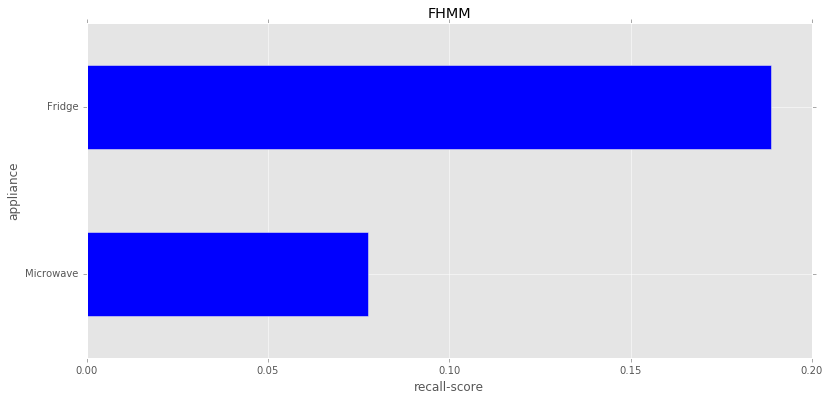

In [9]:
# make plot of recall metric
recall_fhmm = recall_score(disag_fhmm_elec, test_elec)
print(recall_fhmm)
recall_fhmm.index = disag_fhmm_elec.get_labels(recall_fhmm.index)
recall_fhmm.plot(kind='barh')
plt.ylabel('appliance');
plt.xlabel('recall-score');
plt.title("FHMM");

3     0.492418
18    0.325184
dtype: float64


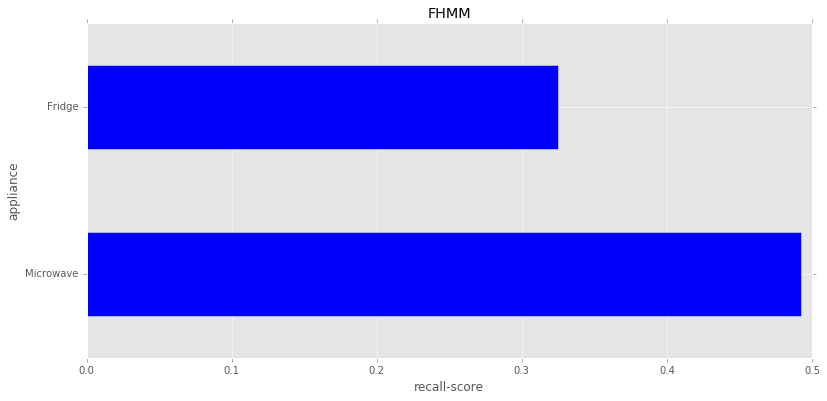

In [10]:
# make plot of precision metric
precision_fhmm = precision_score(disag_fhmm_elec, test_elec)
print(precision_fhmm)
precision_fhmm.index = disag_fhmm_elec.get_labels(precision_fhmm.index)
precision_fhmm.plot(kind='barh')
plt.ylabel('appliance');
plt.xlabel('recall-score');
plt.title("FHMM");

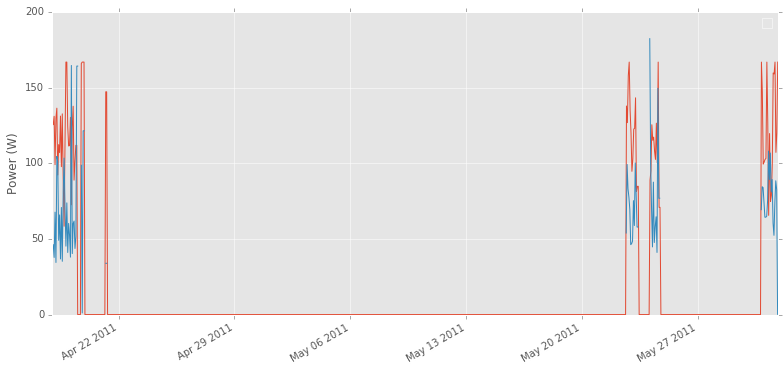

In [26]:
# make plot of actual signal and inferred signal for fridge
a = disag_fhmm_elec['fridge'].plot()
b = test.buildings[test_houses].elec['fridge'].plot()
plt.legend([a, b], ['model', 'truth'])
plt.show()

## Effect of number of hidden states
We modify the train_across_buildings method to allow for a user-specified number of hidden states. We test 2, 3, and 4 hidden states. The third and fourth states account for an intermdeiate state intermediate between the on and off states, or when the device is operating at a lower energy state. 

In [27]:
# initialize FHMM model
fhmm3 = fhmm_exact.FHMM()

# train model
fhmm3.train_across_buildings(train, training_houses, appliances, min_activation=0.001, number_of_states=3, sample_period=10)

Training for fridge
0.237655827726
0.180426424327
0.150136029288
Means for fridge are
[[   4.92977767]
 [ 159.79239518]
 [ 415.13851635]]
Training for microwave
0.0142434597823
0.0417303307202
0.00235112350116
Means for microwave are
[[    3.61779316]
 [ 1358.94446454]
 [   38.14223234]]


In [28]:
# run disaggregation and save to output
disag_filename = 'redd-disag-fhmm_3.h5'
output = HDFDataStore(disag_filename, 'w')
fhmm3.disaggregate_across_buildings(test, output, [test_houses], sample_period=10)
output.close()

Disaggregating for building 5
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading da

In [31]:
# Read disaggreated data
disag_fhmm3 = DataSet(disag_filename)
disag_fhmm3_elec = disag_fhmm3.buildings[test_houses].elec

# compute f1 score
f1_fhmm3 = f1_score(disag_fhmm3_elec, test_elec)
f1_fhmm3.index = disag_fhmm3_elec.get_labels(f1_fhmm3.index)
print(f1_fhmm3)

Microwave    0.113713
Fridge       0.553852
dtype: float64


In [32]:
# repeat with 4 hidden states
# initialize FHMM model
fhmm4 = fhmm_exact.FHMM()

# train model
fhmm4.train_across_buildings(train, training_houses, appliances, min_activation=0.001, number_of_states=4, sample_period=10)

# run disaggregation and save to output
disag_filename = 'redd-disag-fhmm_4.h5'
output = HDFDataStore(disag_filename, 'w')
fhmm4.disaggregate_across_buildings(test, output, [test_houses], sample_period=10)
output.close()

# Read disaggreated data
disag_fhmm4 = DataSet(disag_filename)
disag_fhmm4_elec = disag_fhmm4.buildings[test_houses].elec

# compute f1 score
f1_fhmm4 = f1_score(disag_fhmm4_elec, test_elec)
f1_fhmm4.index = disag_fhmm3_elec.get_labels(f1_fhmm4.index)
print(f1_fhmm4)

Training for fridge
0.237655827726
0.180426424327
0.150136029288
Means for fridge are
[[   4.92307212]
 [ 160.94252585]
 [ 163.30447188]
 [ 417.37749124]]
Training for microwave
0.0142434597823
0.0417303307202
0.00235112350116
Means for microwave are
[[    3.61712174]
 [ 1579.34877745]
 [  520.75535362]
 [   38.36241004]]
Disaggregating for building 5
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for mete

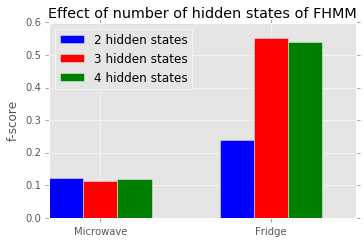

In [71]:
# make comparison figure
fig = plt.gcf()
fig.set_size_inches(5.5, 3.5)
bar2 = plt.bar([1,2], f1_fhmm.values, [0.2, 0.2], label='2 hidden states', color='b')
bar3 = plt.bar([1.2,2.2], f1_fhmm3.values, [0.2, 0.2], label='3 hidden states', color='r')
bar4 = plt.bar([1.4,2.4], f1_fhmm4.values, [0.2, 0.2], label='4 hidden states', color='green')
plt.ylabel('f-score')
plt.title('Effect of number of hidden states of FHMM')
plt.xticks([1.3, 2.3], ('Microwave', 'Fridge'))
plt.legend(loc=2)
plt.savefig('num_states.pdf')

## Improved FHMM implementation: using Gaussian mixtures as emission
The emission probabilties in the NILMTK implementation are Gaussian. This means that given a certain hidden state, the probability of the meter reading follows a Gaussian distribution. An alternative is to model the emissions as a Gaussian Mixture. This has the potential to improve the model because we are only inferring the hidden states of two appliances, but the mains reading will include appliances that the model is not trained on. So for example, when the fridge is on, the observed signal can be multi-modal. 

In [29]:
from nilmtk.disaggregate import fhmm_improved
reload(fhmm_improved)
fhmm2 = fhmm_improved.FHMM()
# Note that we have given the sample period to downsample the data to 1 minute
fhmm2.train_across_buildings(train, training_houses, ['fridge', 'microwave'], sample_period=60, min_activation=0.001)

Training for fridge


TypeError: __init__() got an unexpected keyword argument 'verbose'

In [108]:
output.close()
disag_filename = 'redd-disag-fhmm_gmm2.h5'
output = HDFDataStore(disag_filename, 'w')
# Note that we have mentioned to disaggregate after converting to a sample period of 60 seconds
fhmm2.disaggregate_across_buildings(test, output, [test_houses], sample_period=60)
output.close()

Disaggregating for building 5
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading da

NotFittedError: This GMM instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

4     0.000000
5     0.155093
18    0.589505
dtype: float64


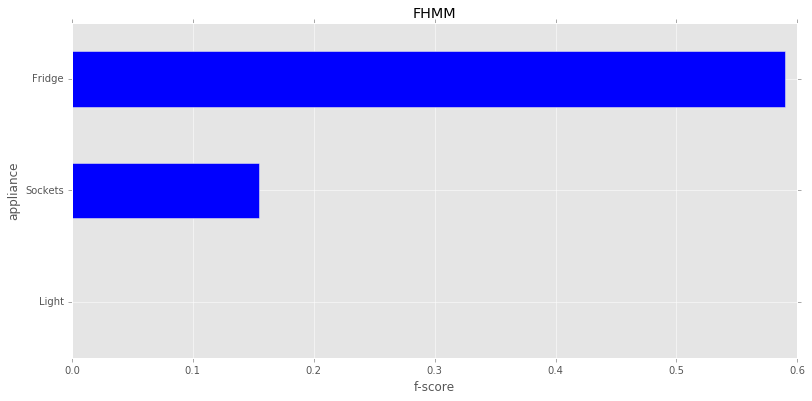

In [104]:
# Read disaggreated data
disag_fhmm = DataSet(disag_filename)
disag_fhmm_elec = disag_fhmm.buildings[test_houses].elec

# make plots of f1 score
f1_fhmm = f1_score(disag_fhmm_elec, test_elec)
print(f1_fhmm)
f1_fhmm.index = disag_fhmm_elec.get_labels(f1_fhmm.index)
f1_fhmm.plot(kind='barh')
plt.ylabel('appliance');
plt.xlabel('f-score');
plt.title("FHMM");

In [36]:
reload(fhmm_exact)
fhmm4 = fhmm_exact.FHMM()
# Note that we have given the sample period to downsample the data to 1 minute
fhmm4.train_across_buildings(train, training_houses, appliances, min_activation=0.001, number_of_states=4, sample_period=60)

Training for fridge
0.251938355509
0.187561165591
0.15943511758
Means for fridge are
[[   4.99456499]
 [ 162.32227001]
 [ 404.97821923]
 [  77.4530577 ]]
Training for microwave
0.0180721738298
0.0425612654537
0.00272830147731
Means for microwave are
[[    3.60879883]
 [ 1498.92432184]
 [   44.59097162]
 [  496.8786807 ]]


In [37]:
disag_filename = 'redd-disag-fhmm_4.h5'
output = HDFDataStore(disag_filename, 'w')
# Note that we have mentioned to disaggregate after converting to a sample period of 60 seconds
fhmm4.disaggregate_across_buildings(test, output, [test_houses], sample_period=60)
output.close()

Disaggregating for building 5
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading da

3     0.126807
18    0.542834
dtype: float64


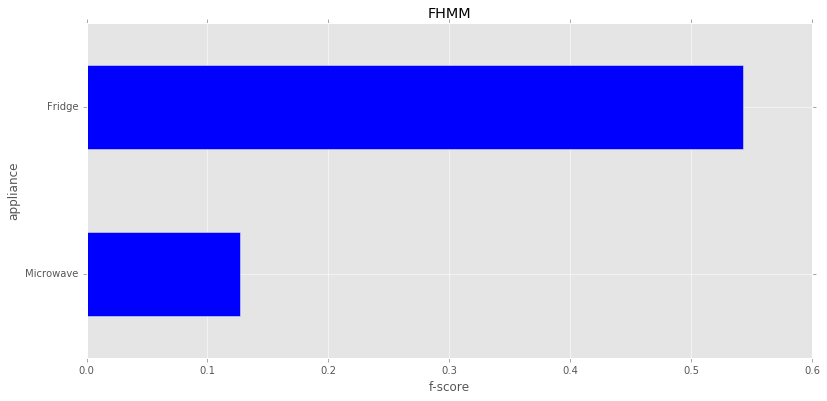

In [38]:
# Read disaggreated data
disag_fhmm = DataSet(disag_filename)
disag_fhmm_elec = disag_fhmm.buildings[test_houses].elec

# make plots of f1 score
f1_fhmm = f1_score(disag_fhmm_elec, test_elec)
print(f1_fhmm)
f1_fhmm.index = disag_fhmm_elec.get_labels(f1_fhmm.index)
f1_fhmm.plot(kind='barh')
plt.ylabel('appliance');
plt.xlabel('f-score');
plt.title("FHMM");